

```
# 1) Choose any dataset of your choice from Kaggle.
#2) Implement word-frequency or bag of words models on suitable columns of the dataset and visualize the analytics it offers. [5 points]
#3) Implement unigram, bigram and trigram models to check frequent word pairs (inter or intra column text). [5 points]
#4) Implement TF-IDF models to summarize text in the dataset [5 points]
#5) Submit a 3 page report on your analytics. [5 points]

#Extra Credit 4 points: Implement word2vec models and compare it with any one #of the models.
```



In [1]:
#mount my google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import the dataset by going into drive, then MyDrive then click the folder then "copy path"
import pandas as pd
debate = pd.read_csv("/content/drive/MyDrive/AAT Final Project/us_election_2020_1st_presidential_debate.csv")

In [ ]:
#import all the libraries and tools we may need

#import basic python libraries
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#import nltk tools
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import bigrams
from nltk.lm.preprocessing import pad_both_ends, flatten, padded_everygram_pipeline
from nltk.lm import MLE

#import additional preprocessing tools for strings, patterns and token counting
import string
import re
from collections import Counter

#import modeling tools
import heapq
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install gensim
#import gensim #- gensim worked...then it didn't I do not know how to fix this
#from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#get a feel for the dataset
debate.head(5)

#from here we can see that there are 3 people debating (column 1 differentiates that),
#a minute marker for when people speak
#and the unstructured text of what they say

,speaker,minute,text
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"
3,President Donald J. Trump,02:51,How are you doing?
4,Vice President Joe Biden,02:51,I’m well.


In [ ]:
debate.tail(5)
#and hear we can see that there are 788 total rows, totaling just over 1hr 10 minutes

#the key here will be to separate out Biden's corpus and Trump's corpus and compare them - should be fun

,speaker,minute,text
784,Chris Wallace,01:10:43,"Gentlemen, just say that’s the end of it [cros..."
785,President Donald J. Trump,01:10:47,I want to see an honest ballot count.
786,Chris Wallace,01:10:48,We’re going to leave it there-
787,President Donald J. Trump,01:10:49,And I think he does too-
788,Chris Wallace,01:10:50,… to be continued in more debates as we go on....


In [ ]:
#let's check to make sure python understands what we are working with

debate.dtypes
#good, it is treating our text as an object and not anything wonky

,0
speaker,object
minute,object
text,object


In [ ]:
#let's drop the minute column - we won't be needing it
debate1 = debate.drop(['minute'], axis=1)
debate1.head(5)

,speaker,text
0,Chris Wallace,Good evening from the Health Education Campus ...
1,Chris Wallace,This debate is being conducted under health an...
2,Vice President Joe Biden,"How you doing, man?"
3,President Donald J. Trump,How are you doing?
4,Vice President Joe Biden,I’m well.


In [ ]:
# now I want to create two separate entities for Biden and Trump, respectively

bidentext = debate1[debate1['speaker'] == 'Vice President Joe Biden']
trumptext = debate1[debate1['speaker'] == 'President Donald J. Trump']

#get a quick check to make sure this worked
bidentext.head(10) #-- this is our set of rows that we will turn into our Biden Corpus
trumptext.head(10) #-- this is our set of rows that we will turn into our Trump Corpus

,speaker,text
3,President Donald J. Trump,How are you doing?
6,President Donald J. Trump,"Thank you very much, Chris. I will tell you ve..."
7,President Donald J. Trump,And we won the election and therefore we have ...
10,President Donald J. Trump,"Thank you, Joe."
14,President Donald J. Trump,There aren’t a hundred million people with pre...
16,President Donald J. Trump,"During that period of time, during that period..."
18,President Donald J. Trump,"Well, you’re certainly going to socialist. You..."
23,President Donald J. Trump,That’s not what you’ve said and it’s not what ...
25,President Donald J. Trump,Your party doesn’t say it. Your party wants to...
27,President Donald J. Trump,"And they’re going to dominate you, Joe. You kn..."


In [ ]:
#next, we will concat all of biden's words into one big list
#this will be our corpus for Biden
bidencorpus = ' '.join(bidentext['text'].astype(str).tolist())
bidencorpus = bidencorpus.lower() #this fixes so many issues/repeated steps down the road - lower case the whole thing up front
print(bidencorpus) #make sure it worked

#do the same for trump
trumpcorpus = ' '.join(trumptext['text'].astype(str).tolist())
trumpcorpus = trumpcorpus.lower() #same
print(trumpcorpus) #make sure it worked

how you doing, man? i’m well. well, first of all, thank you for doing this and looking forward to this, mr. president. the american people have a right to have a say in who the supreme court nominee is and that say occurs when they vote for united states senators and when they vote for the president of united states. they’re not going to get that chance now because we’re in the middle of an election already. the election has already started. tens of thousands of people already voted and so the thing that should happen is we should wait. we should wait and see what the outcome of this election is because that’s the only way the american people get to express their view is by who they elect as president and who they elect as vice president. now, what’s at stake here is the president’s made it clear, he wants to get rid of the affordable care act. he’s been running on that, he ran on that and he’s been governing on that. he’s in the supreme court right now trying to get rid of the afforda

In [ ]:
###################################### WORD FREQUENCY MODEL ############################################

In [ ]:
#now we need to tokenize these corpi so we can use a word frequency model on them

bidenwords = nltk.word_tokenize(bidencorpus.lower())
trumpwords = nltk.word_tokenize(trumpcorpus.lower())

print(bidenwords)
print(trumpwords)

print(len(bidenwords)) #biden talks about 12% less than trump does
print(len(trumpwords))

['how', 'you', 'doing', ',', 'man', '?', 'i', '’', 'm', 'well', '.', 'well', ',', 'first', 'of', 'all', ',', 'thank', 'you', 'for', 'doing', 'this', 'and', 'looking', 'forward', 'to', 'this', ',', 'mr.', 'president', '.', 'the', 'american', 'people', 'have', 'a', 'right', 'to', 'have', 'a', 'say', 'in', 'who', 'the', 'supreme', 'court', 'nominee', 'is', 'and', 'that', 'say', 'occurs', 'when', 'they', 'vote', 'for', 'united', 'states', 'senators', 'and', 'when', 'they', 'vote', 'for', 'the', 'president', 'of', 'united', 'states', '.', 'they', '’', 're', 'not', 'going', 'to', 'get', 'that', 'chance', 'now', 'because', 'we', '’', 're', 'in', 'the', 'middle', 'of', 'an', 'election', 'already', '.', 'the', 'election', 'has', 'already', 'started', '.', 'tens', 'of', 'thousands', 'of', 'people', 'already', 'voted', 'and', 'so', 'the', 'thing', 'that', 'should', 'happen', 'is', 'we', 'should', 'wait', '.', 'we', 'should', 'wait', 'and', 'see', 'what', 'the', 'outcome', 'of', 'this', 'election'

In [ ]:
#after this, it is time to remove the stopwards so we can get a realistic vocabulary and reduce size

#biden stopword removal
stop_words = set(stopwords.words('english'))
biden_filtered_words = [word for word in bidenwords if word not in stop_words and word not in string.punctuation]
print(biden_filtered_words)

#trump stopword removal
stop_words = set(stopwords.words('english'))
trump_filtered_words = [word for word in trumpwords if word not in stop_words and word not in string.punctuation]
print(trump_filtered_words)

print(len(biden_filtered_words)) #reduces down to 3251
print(len(trump_filtered_words)) #and 3698


####look at this #### -- it removes "won" as a stopword -- why is this?

['man', '’', 'well', 'well', 'first', 'thank', 'looking', 'forward', 'mr.', 'president', 'american', 'people', 'right', 'say', 'supreme', 'court', 'nominee', 'say', 'occurs', 'vote', 'united', 'states', 'senators', 'vote', 'president', 'united', 'states', '’', 'going', 'get', 'chance', '’', 'middle', 'election', 'already', 'election', 'already', 'started', 'tens', 'thousands', 'people', 'already', 'voted', 'thing', 'happen', 'wait', 'wait', 'see', 'outcome', 'election', '’', 'way', 'american', 'people', 'get', 'express', 'view', 'elect', 'president', 'elect', 'vice', 'president', '’', 'stake', 'president', '’', 'made', 'clear', 'wants', 'get', 'rid', 'affordable', 'care', 'act', '’', 'running', 'ran', '’', 'governing', '’', 'supreme', 'court', 'right', 'trying', 'get', 'rid', 'affordable', 'care', 'act', 'strip', '20', 'million', 'people', 'health', 'insurance', 'goes', 'court', 'justice', '’', 'opposed', 'justice', 'seems', 'like', 'fine', 'person', '’', 'written', 'went', 'bench', 'r

In [ ]:
#next we can count this new filtered vocabulary frequency

# Count biden word frequency
word_freqb = Counter(biden_filtered_words)
print(word_freqb)
# Get the 40 most common words
common_wordsb = word_freqb.most_common(60)
print(   )
print(common_wordsb)
print(   )
# Count trump word frequency
word_freqt = Counter(trump_filtered_words)
print(word_freqt)
# Get the 40 most common words
common_wordst = word_freqt.most_common(60)
print(   )
print(common_wordst)

Counter({'’': 310, 'people': 73, 'going': 60, 'fact': 37, 'way': 31, 'get': 27, 'crosstalk': 25, 'well': 24, 'look': 23, 'president': 22, 'deal': 22, 'vote': 21, 'number': 21, 'one': 21, 'said': 21, 'true': 20, 'like': 19, 'make': 18, 'sure': 18, 'take': 18, 'able': 17, 'know': 17, 'plan': 16, 'say': 15, 'tax': 15, 'american': 14, 'want': 14, 'states': 13, 'open': 13, 'got': 13, 'jobs': 13, 'man': 12, 'covid': 12, 'would': 12, 'election': 11, 'done': 11, 'back': 11, 'care': 10, 'million': 10, 'two': 10, 'talking': 10, 'even': 10, '…': 10, 'court': 9, 'money': 9, 'many': 9, 'talk': 9, 'let': 9, 'lot': 9, 'never': 9, 'ballots': 9, 'right': 8, 'united': 8, 'made': 8, 'good': 8, 'go': 8, 'us': 8, 'economy': 8, 'totally': 8, 'america': 8, 'wants': 7, 'person': 7, 'went': 7, 'could': 7, 'away': 7, 'ballot': 7, 'healthcare': 7, 'time': 7, '“': 7, '”': 7, 'anything': 7, 'job': 7, 'need': 7, 'create': 7, 'police': 7, 'forward': 6, 'thousands': 6, 'happen': 6, 'act': 6, 'trying': 6, 'still': 6, 

In [ ]:
#this is not as usable as I'd like, yet because it still has stopwords I don't want
#these stop words don't tell a story in the data (which we will primarily get from nouns and action verbs)
#so I will create a custom list of stopwords to further filter

# i later learned that "crosstalk" was not a word they were saying but was the
#language detection model's token for when they both were talking at once.
#I have, thus, deleted it as well
custom_stop_words = ['crosstalk',',', 'going', 'way', 'get' , 'like', 'got', 'would' , '…', 'could', '’', '“', '”' ]
biden_filtered_words = [word for word in biden_filtered_words if word not in custom_stop_words]
trump_filtered_words = [word for word in trump_filtered_words if word not in custom_stop_words]

#recount biden word frequency
word_freqb = Counter(biden_filtered_words)
print(word_freqb)
# Get the 60 most common biden words
common_wordsb_60 = word_freqb.most_common(60)
print(   )
print(common_wordsb_60)
print(   )
#recount trump word frequency
word_freqt = Counter(trump_filtered_words)
print(word_freqt)
# Get the 60 most common trump words
common_wordst_60 = word_freqt.most_common(60)
print(   )
print(common_wordst_60)

#good, now this is more usable and eliminates a lot of punctuation and useless words did not catch

Counter({'people': 73, 'fact': 37, 'well': 24, 'look': 23, 'president': 22, 'deal': 22, 'vote': 21, 'number': 21, 'one': 21, 'said': 21, 'true': 20, 'make': 18, 'sure': 18, 'take': 18, 'able': 17, 'know': 17, 'plan': 16, 'say': 15, 'tax': 15, 'american': 14, 'want': 14, 'states': 13, 'open': 13, 'jobs': 13, 'man': 12, 'covid': 12, 'election': 11, 'done': 11, 'back': 11, 'care': 10, 'million': 10, 'two': 10, 'talking': 10, 'even': 10, 'court': 9, 'money': 9, 'many': 9, 'talk': 9, 'let': 9, 'lot': 9, 'never': 9, 'ballots': 9, 'right': 8, 'united': 8, 'made': 8, 'good': 8, 'go': 8, 'us': 8, 'economy': 8, 'totally': 8, 'america': 8, 'wants': 7, 'person': 7, 'went': 7, 'away': 7, 'ballot': 7, 'healthcare': 7, 'time': 7, 'anything': 7, 'job': 7, 'need': 7, 'create': 7, 'police': 7, 'forward': 6, 'thousands': 6, 'happen': 6, 'act': 6, 'trying': 6, 'still': 6, 'shut': 6, 'matter': 6, 'everything': 6, 'everybody': 6, 'wrong': 6, 'guy': 6, 'help': 6, 'day': 6, 'give': 6, 'nothing': 6, 'bring': 6

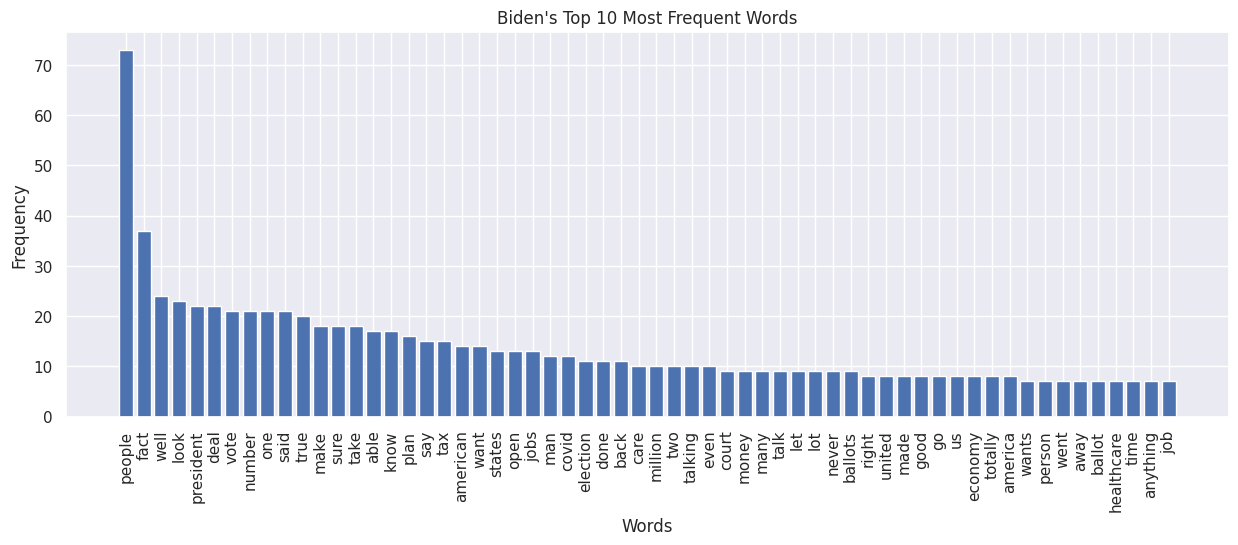

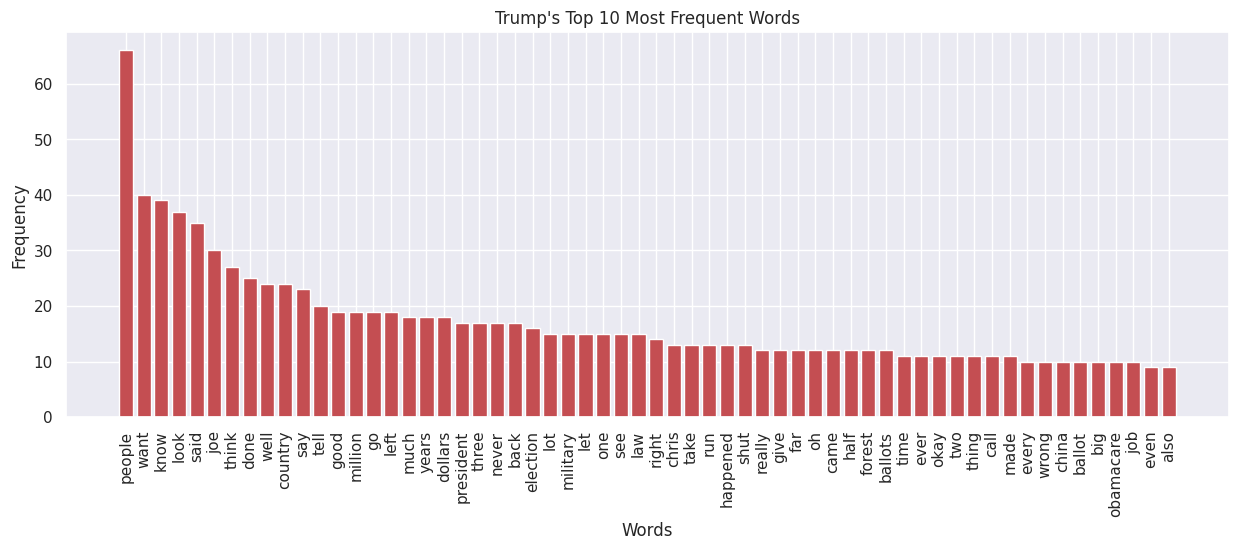

In [ ]:
#lets get a preliminary view of how these two candidates used their 60 most common
#words during the debate

#make biden's histogram
words, counts = zip(*common_wordsb_60)
plt.figure(figsize=(15, 5))
plt.bar(words, counts, color='b')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Biden's Top 10 Most Frequent Words")
plt.xticks(rotation=90) #don't use the 45 degree like in our class example
plt.show()

#make trumps histogram
words, counts = zip(*common_wordst_60)
plt.figure(figsize=(15, 5))
plt.bar(words, counts, color='r')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Trump's Top 10 Most Frequent Words")
plt.xticks(rotation=90) #bc it will overlap words onto eachother
plt.show()

In [ ]:
#here we can see that, both candidates talked about the people and
#from these filtered top 60 words:

#trumps top 10 words were heavily focused on joe and the country
#biden's top 10 words focused on numbers, facts, votes and the presidency

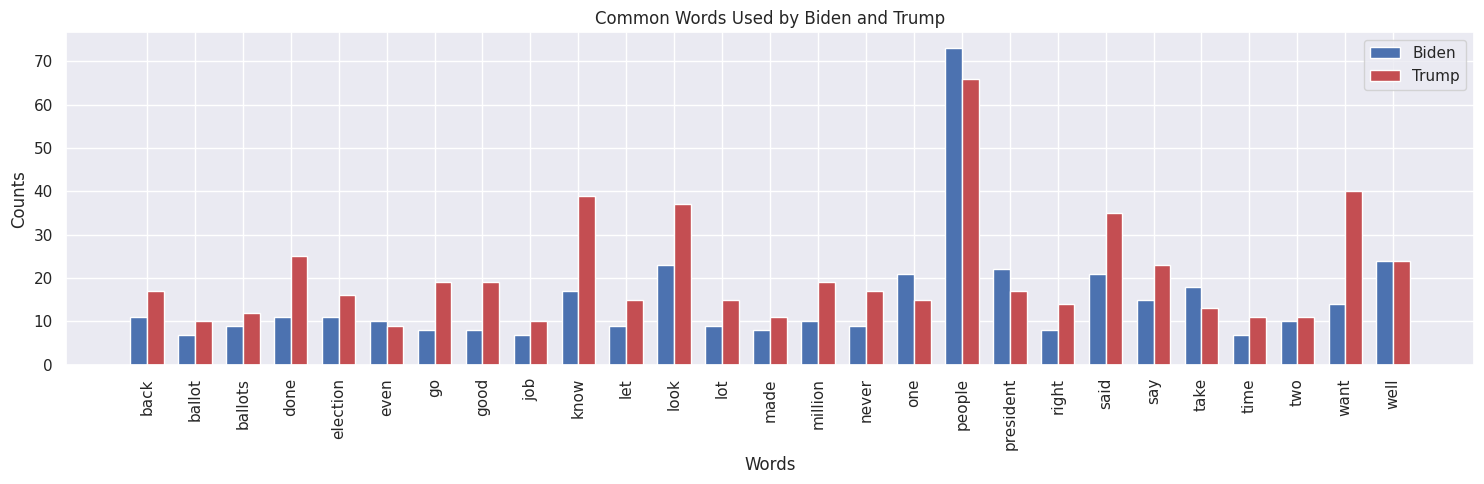

In [ ]:
# from here, we can see some initial counts but it is tough to visualize the differences
#so to compare the use of shared words, i can create a paired histogram

#this will work better as dictionaries
biden_dict_60 = dict(common_wordsb_60)
trump_dict_60 = dict(common_wordst_60)

#create an object to identify words they both say
shared_words = set(biden_dict_60.keys()).intersection(set(trump_dict_60.keys()))

#let's get them in alphabetical order
aplha_shared_words = sorted(shared_words)

#prepare this data for plotting
biden_counts_60 = [biden_dict_60[word] for word in aplha_shared_words]
trump_counts_60 = [trump_dict_60[word] for word in aplha_shared_words]

#make the plot
x = np.arange(len(aplha_shared_words))
width = 0.35

plt.figure(figsize=(15, 5))
plt.bar(x - width/2, biden_counts_60, width, label='Biden', color='b')
plt.bar(x + width/2, trump_counts_60, width, label='Trump', color='r')

plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Common Words Used by Biden and Trump")
plt.xticks(x, aplha_shared_words, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#now we can see differences between their shared words
#for example:
#trump said more of EVERY word except for 5 of them
#both said people the most but biden said it more
#both candidates spoke frequently about ballots and the election

#this is useful, but we should also consider what words they said that were UNIQUE to their speeches

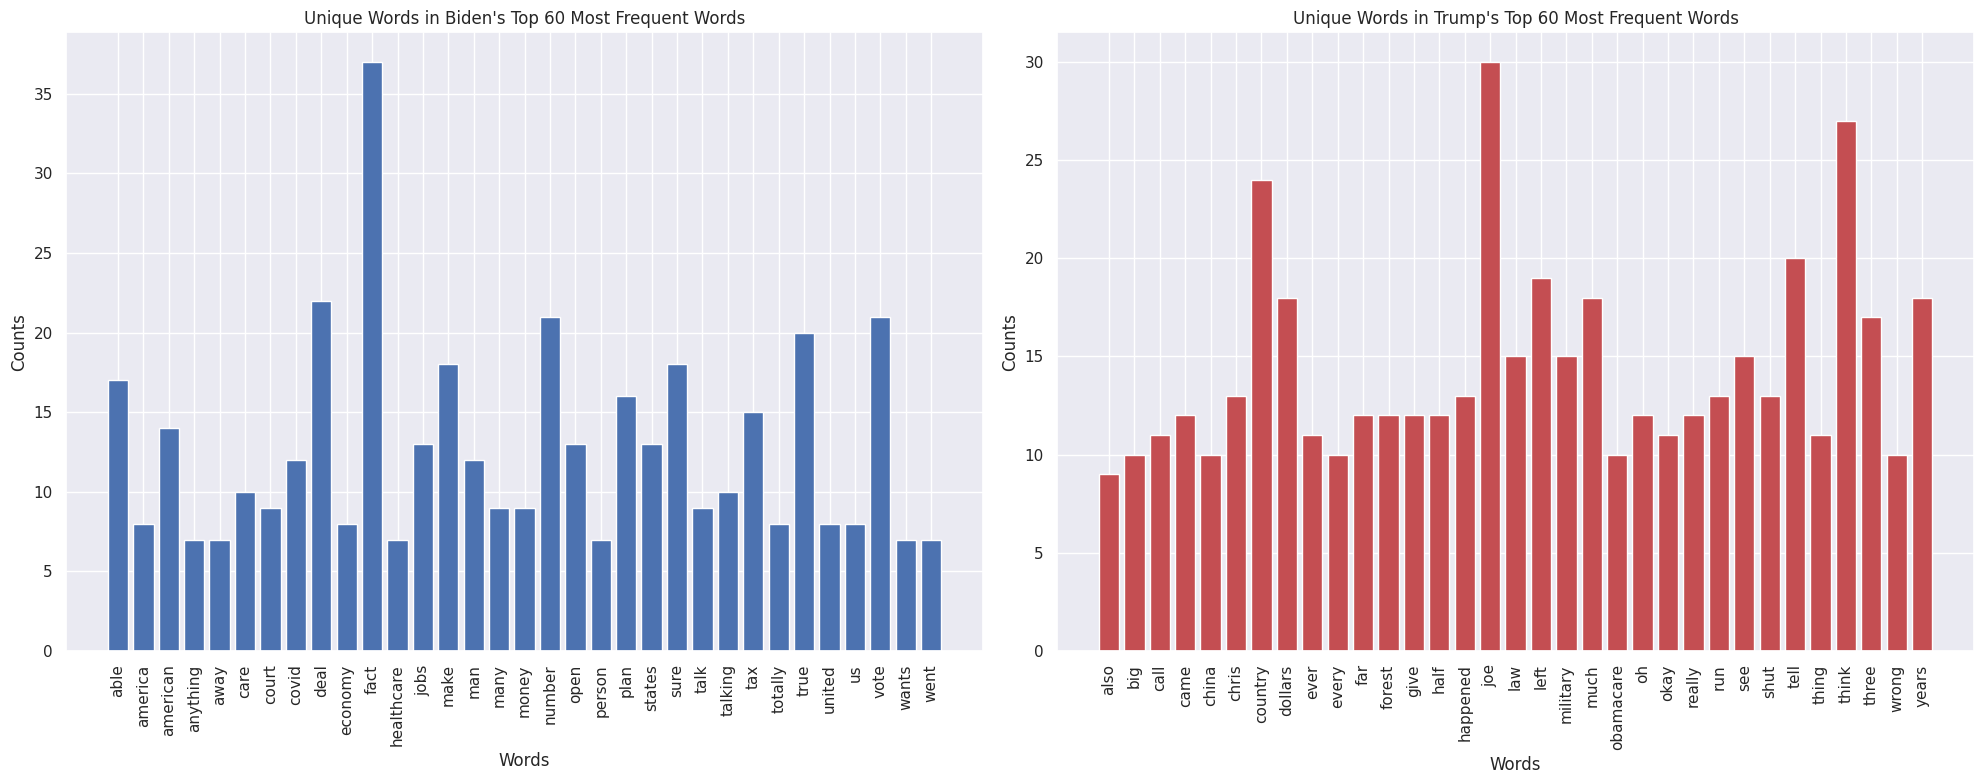

In [ ]:
#first i have to find the unique qwords they each said
biden_unique_words = set(biden_dict_60.keys()) - set(trump_dict_60.keys())
trump_unique_words = set(trump_dict_60.keys()) - set(biden_dict_60.keys())

#to keep plot consistency, i sorted these alphabetically but it might make more sense to put them in order of count(?)
alpha_biden_unique_words = sorted(biden_unique_words)
alpha_trump_unique_words = sorted(trump_unique_words)

#creat the counts for the y axis
biden_counts_unique = [biden_dict_60[word] for word in alpha_biden_unique_words]
trump_counts_unique = [trump_dict_60[word] for word in alpha_trump_unique_words]

#make the histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

#biden's unique words plot
ax1.bar(alpha_biden_unique_words, biden_counts_unique, color='b')
ax1.set_xlabel("Words")
ax1.set_ylabel("Counts")
ax1.set_title("Unique Words in Biden's Top 60 Most Frequent Words") #feel free to rename these, the names are clunky
ax1.set_xticklabels(alpha_biden_unique_words, rotation=90)

#trump's unique words plot
ax2.bar(alpha_trump_unique_words, trump_counts_unique, color='r')
ax2.set_xlabel("Words")
ax2.set_ylabel("Counts")
ax2.set_title("Unique Words in Trump's Top 60 Most Frequent Words") #but we need to express that they are only unique to their respective top 60's
ax2.set_xticklabels(alpha_trump_unique_words, rotation=90)

fig.tight_layout()
plt.show()

In [ ]:
#now we can see which of their top 60 words they said that were DIFFERENT
#this may even be more informative

#all results below assume that we are operating in each of their top 60 words

#trump never said america, american, united, or states - odd
#biden talked about the courts and covid while trump did not
#biden talked about the economy and healthcare while trump talked about the country and obamacare
#biden talked about jobs, taxes and votes while trump stressed china and the military
#biden stressed facts and the truth (via "true"), numbers and plans while trump talked about joe(biden)
#overall, within these top 60 words, filtered by uniqueness, biden said more nouns(adjusted, 17) than trump (11)
#trump uses people's names more and many more verbs
# a preliminary look between the two shows that Biden focused much more heavily
#on debate words (issues voters might be concerned about) than trump who mostly used filler words

In [ ]:
####################################### BIGRAM AND TRIGRAM MODELS ##################################################

In [ ]:
#using bidencorpus and trumpcorpus here

#process Biden's corpus
#first make into sentences
bidensentences = sent_tokenize(bidencorpus)

#i think it is an interesting idea to see the average sentence length
biden_sentence_lengths = [len(sentence.split()) for sentence in bidensentences]

# Compute the average length
biden_average_length = sum(biden_sentence_lengths) / len(biden_sentence_lengths)

print(biden_average_length) #biden's average sentence is 11.3 words long
print(   )
biden_ngram_processed_corpus = []

for sentence in bidensentences:
    tokens = word_tokenize(sentence)
    biden_ngram_processed_corpus.append([token for token in tokens if token.isalpha()]) # and token not in stop_words and token not in custom_stop_words])
    #I have chosen to comment out our stopword removal. It made sense to remove stopwords for word freq but now that we are not working with such
    #simple models, removing these stopwords really limits the context and insights we can gain from seeing how each of them speakprint(biden_ngram_processed_corpus)
print(biden_ngram_processed_corpus)

#process trump's corpus
#first make into sentences
trumpsentences = sent_tokenize(trumpcorpus)

#do the same length measurement for trump
trump_sentence_lengths = [len(sentence.split()) for sentence in trumpsentences]

# Compute the average length
trump_average_length = sum(trump_sentence_lengths) / len(trump_sentence_lengths)
print(   )
print(trump_average_length) #trump's average sentence is 10 words long

#we know that trump talks 12% more than biden in this debate
#but now we know that this is DESPITE saying fewer words per sentence

trump_ngram_processed_corpus = []

for sentence in trumpsentences:
    tokens = word_tokenize(sentence)
    trump_ngram_processed_corpus.append([token for token in tokens if token.isalpha()]) #and token not in stop_words and token not in custom_stop_words])


print(   )
print(trump_ngram_processed_corpus)

11.297435897435898

[['how', 'you', 'doing', 'man'], ['i', 'm', 'well'], ['well', 'first', 'of', 'all', 'thank', 'you', 'for', 'doing', 'this', 'and', 'looking', 'forward', 'to', 'this', 'president'], ['the', 'american', 'people', 'have', 'a', 'right', 'to', 'have', 'a', 'say', 'in', 'who', 'the', 'supreme', 'court', 'nominee', 'is', 'and', 'that', 'say', 'occurs', 'when', 'they', 'vote', 'for', 'united', 'states', 'senators', 'and', 'when', 'they', 'vote', 'for', 'the', 'president', 'of', 'united', 'states'], ['they', 're', 'not', 'going', 'to', 'get', 'that', 'chance', 'now', 'because', 'we', 're', 'in', 'the', 'middle', 'of', 'an', 'election', 'already'], ['the', 'election', 'has', 'already', 'started'], ['tens', 'of', 'thousands', 'of', 'people', 'already', 'voted', 'and', 'so', 'the', 'thing', 'that', 'should', 'happen', 'is', 'we', 'should', 'wait'], ['we', 'should', 'wait', 'and', 'see', 'what', 'the', 'outcome', 'of', 'this', 'election', 'is', 'because', 'that', 's', 'the', 'on

In [ ]:
#moving fwd with bigram model - here is an example of what is happening on the backend
#just with biden's corpus

# Display the first processed sentence
biden_first_sent = biden_ngram_processed_corpus[0]
print(biden_first_sent)

# Generate original bigrams (word pairs)
original_bigrams = list(bigrams(biden_first_sent))
print("Original bigrams:", original_bigrams)

padded_sentence = list(pad_both_ends(biden_first_sent, n=2))
print("Padded sentence:", padded_sentence)

# Generate bigrams again after padding
bigrams_post_padding = list(bigrams(padded_sentence))
print("Bigrams after padding:", bigrams_post_padding)

['how', 'you', 'doing', 'man']
Original bigrams: [('how', 'you'), ('you', 'doing'), ('doing', 'man')]
Padded sentence: ['<s>', 'how', 'you', 'doing', 'man', '</s>']
Bigrams after padding: [('<s>', 'how'), ('how', 'you'), ('you', 'doing'), ('doing', 'man'), ('man', '</s>')]


In [ ]:
##### to my understanding, i missed this lecture bc of my cat, we do not need to do this on our end
##### the following steps will do all the work of preparing the data for the model

In [ ]:
#prepare biden's data for the bigram model
#it's crucial here to amend professor's code, since we are training two models,
#to make sure that all variables are uniqur to the two corpi

bidentrain, bidenvocab = padded_everygram_pipeline(2, biden_ngram_processed_corpus)

#initialize and train the Maximum Likelihood Estimation (MLE) bigram model
biden_lm = MLE(2)
biden_lm.fit(bidentrain, bidenvocab)

#prepare trump's data for the bigram model
trumptrain, trumpvocab = padded_everygram_pipeline(2, trump_ngram_processed_corpus)

#initialize and train the Maximum Likelihood Estimation (MLE) bigram model
trump_lm = MLE(2)
trump_lm.fit(trumptrain, trumpvocab)


In [ ]:
#just to check, let's display vocabulary size
print("Biden's vocabulary size:", len(biden_lm.vocab)) #biden says 1133 unique words
print("Trump's vocabulary size:", len(trump_lm.vocab)) #and trump says 1049 (trump also says fewer unique words)
#aka a smaller vocab for the debate despite talking more

#check vocabulary lookup for some of their longer sentences
#i didn't just use the first sentence like in professor's example bc both were short "hey man" type sentences
print("Vocabulary lookup for third sentence:", biden_lm.vocab.lookup(biden_ngram_processed_corpus[2]))
#takes his 3rd sentence and prints the vocab
print("Vocabulary lookup for unknown words:", biden_lm.vocab.lookup(["aliens", "from", "mars"])) #used from to make sure stopwords were still in

#same for trump
print("Vocabulary lookup for 6th sentence:", trump_lm.vocab.lookup(trump_ngram_processed_corpus[5]))
print("Vocabulary lookup for unknown words:", trump_lm.vocab.lookup(["aliens", "from", "mars"]))

Biden's vocabulary size: 1133
Trump's vocabulary size: 1049
Vocabulary lookup for third sentence: ('well', 'first', 'of', 'all', 'thank', 'you', 'for', 'doing', 'this', 'and', 'looking', 'forward', 'to', 'this', 'president')
Vocabulary lookup for unknown words: ('<UNK>', 'from', '<UNK>')
Vocabulary lookup for 6th sentence: ('we', 'have', 'the', 'senate', 'we', 'have', 'the', 'white', 'house', 'and', 'we', 'have', 'a', 'phenomenal', 'nominee', 'respected', 'by', 'all')
Vocabulary lookup for unknown words: ('<UNK>', 'from', '<UNK>')


In [ ]:
#now, to check for unique (and meaningful) bigrams, we want to eliminate stopwords
#we built the model on their whole vocab (that is, their way of speaking)
#but to look for insightful word pairings, we need to eliminate filler words and apostrophes, etc.

biden_ngram_processed_corpus_nostop = [] #rename the new processed corpus
for sentence in bidensentences: #take the same sentence tokenized corpus from before, we can recycle this
    tokens1 = word_tokenize(sentence)  #reassign a new object for the tokens
    biden_ngram_processed_corpus_nostop.append([token for token in tokens1 if token.isalpha() and token not in stop_words and token not in custom_stop_words])
    #I have chosen to comment out our stopword removal. It made sense to remove stopwords for word freq but now that we are not working with such
    #simple models, removing these stopwords really limits the context and insights we can gain from seeing how each of them speakprint(biden_ngram_processed_corpus)
print(biden_ngram_processed_corpus_nostop)

#now we have a list of sentences that has none of our stopwords

#to the same thing for trump

print (   )

trump_ngram_processed_corpus_nostop = [] #rename the new processed corpus
for sentence in trumpsentences: #take the same sentence tokenized corpus from before, we can recycle this
    tokens2 = word_tokenize(sentence)  #reassign a new object for the tokens
    trump_ngram_processed_corpus_nostop.append([token for token in tokens2 if token.isalpha() and token not in stop_words and token not in custom_stop_words])
    #I have chosen to comment out our stopword removal. It made sense to remove stopwords for word freq but now that we are not working with such
    #simple models, removing these stopwords really limits the context and insights we can gain from seeing how each of them speakprint(biden_ngram_processed_corpus)
print(trump_ngram_processed_corpus_nostop)

[['man'], ['well'], ['well', 'first', 'thank', 'looking', 'forward', 'president'], ['american', 'people', 'right', 'say', 'supreme', 'court', 'nominee', 'say', 'occurs', 'vote', 'united', 'states', 'senators', 'vote', 'president', 'united', 'states'], ['chance', 'middle', 'election', 'already'], ['election', 'already', 'started'], ['tens', 'thousands', 'people', 'already', 'voted', 'thing', 'happen', 'wait'], ['wait', 'see', 'outcome', 'election', 'american', 'people', 'express', 'view', 'elect', 'president', 'elect', 'vice', 'president'], ['stake', 'president', 'made', 'clear', 'wants', 'rid', 'affordable', 'care', 'act'], ['running', 'ran', 'governing'], ['supreme', 'court', 'right', 'trying', 'rid', 'affordable', 'care', 'act', 'strip', 'million', 'people', 'health', 'insurance', 'goes', 'court'], ['justice', 'opposed', 'justice', 'seems', 'fine', 'person'], ['written', 'went', 'bench', 'right', 'thinks', 'affordable', 'care', 'act', 'constitutional'], ['thing', 'court', 'struck', '

In [ ]:
#flatten the list of bigrams - this step uses list comprehension to create a list of all biigrams in the corpus
#zipping it pairs each word with the next TWO words
biden_bigrams = [bigram for sentence in biden_ngram_processed_corpus_nostop for bigram in zip(sentence, sentence[1:])]

trump_bigrams = [bigram for sentence in trump_ngram_processed_corpus_nostop for bigram in zip(sentence, sentence[1:])]

#then count them
biden_bigram_counts = Counter(biden_bigrams)
trump_bigram_counts = Counter(trump_bigrams)

#then get the most frequently recurring ones

biden_common_bigrams = biden_bigram_counts.most_common(20)
print("Biden's most common bigrams:", biden_common_bigrams)

trump_common_bigrams = trump_bigram_counts.most_common(20)
print("Trump's most common bigrams:", trump_common_bigrams)
#this gets us their most frequent word pairs (as per the assignment prompt)

#from before, when we had stopwords...
#we can see here that biden talks about the american people, the US and the facts
#where trump says i think, i want, i know, i tell

#when we remove stopwords, we can see that:
#biden talks a lot about the american people and the united states, listing plans and
#arguments by number, affordable care, taking care, making things clear, what people want,
#the outcome of the election, the facts and the democartic party
#whereas, when trump speaks (no stopwords) we see:
#he uses millions a lot to demonstrate his points, he talks about law enforcement,
#law and order, calls out the radical left, mocks with "oh really", people died, look what happened, etc.

#trump uses large numbers in 4/20 of his top bigrams
#trump uses the word people in 4/20 of his top bigrams
#he tries to appeal to the masses by referencing them and using large numbers and bad outcomes to create importance
#biden talks more about the issues (nouns), what the people want and trying to establish facts

Biden's most common bigrams: [(('make', 'sure'), 11), (('american', 'people'), 9), (('number', 'one'), 9), (('united', 'states'), 8), (('number', 'two'), 8), (('affordable', 'care'), 5), (('care', 'act'), 5), (('million', 'people'), 5), (('take', 'care'), 5), (('president', 'united'), 4), (('made', 'clear'), 4), (('people', 'want'), 4), (('totally', 'discredited'), 4), (('green', 'new'), 4), (('new', 'deal'), 4), (('outcome', 'election'), 3), (('vice', 'president'), 3), (('democratic', 'party'), 3), (('people', 'died'), 3), (('fact', 'matter'), 3)]
Trump's most common bigrams: [(('three', 'half'), 10), (('take', 'look'), 9), (('million', 'people'), 8), (('let', 'tell'), 8), (('half', 'million'), 8), (('millions', 'dollars'), 7), (('law', 'enforcement'), 7), (('law', 'order'), 7), (('radical', 'left'), 6), (('oh', 'really'), 6), (('million', 'dollars'), 6), (('individual', 'mandate'), 5), (('go', 'ahead'), 5), (('people', 'died'), 5), (('look', 'happened'), 5), (('said', 'president'), 4

In [ ]:
# for fun :) we also can generate text, given a starting word
#this is back to our WITH STOPWORDS processed corpus (how we built our model) so we can get coherent sentences
biden_generated_text = biden_lm.generate(20, text_seed=['people']) #play around with this, by changing the seed word from their vocab
print("Biden will probably say:", ' '.join(biden_generated_text))

Biden will probably say: a higher deficit with us what he s own homeland security director says that we re closing </s> the thing


In [ ]:
#and here is for trump
trump_generated_text = trump_lm.generate(20, text_seed=['people'])
print("Trump will probably say:", ' '.join(trump_generated_text))

Trump will probably say: we don t know the individual mandate which very happy about defunding the reasons they ve caught them </s> to


In [ ]:
# an interesting thing of note, here, with almost every seed word I've tried...
#biden's corpus makes longer and more coherent sentences than trump's...hmmm

In [ ]:
####################### now for a trigram model ####################################

In [ ]:
#prepare biden's data for the trigram model
#it's crucial here to amend professor's code, since we are training two models,
#to make sure that all variables are uniqur to the two corpi

bidentrain3, bidenvocab3 = padded_everygram_pipeline(3, biden_ngram_processed_corpus) #once again, do this with our WITH STOPWORDS corpus

#initialize and train the Maximum Likelihood Estimation (MLE) bigram model
biden3_lm = MLE(3)
biden3_lm.fit(bidentrain3, bidenvocab3)

#prepare trump's data for the bigram model
trumptrain3, trumpvocab3 = padded_everygram_pipeline(3, trump_ngram_processed_corpus) #once again, do this with our WITH STOPWORDS corpus

#initialize and train the Maximum Likelihood Estimation (MLE) bigram model
trump3_lm = MLE(3)
trump3_lm.fit(trumptrain3, trumpvocab3)

print("Vocabulary lookup (trigram model) for third sentence:", biden3_lm.vocab.lookup(biden_ngram_processed_corpus[2]))
#same for trump
print("Vocabulary lookup for sixth sentence:", trump3_lm.vocab.lookup(trump_ngram_processed_corpus[5]))

#did this vocab lookup to make sure the model was built WITH stopwords

Vocabulary lookup (trigram model) for third sentence: ('well', 'first', 'of', 'all', 'thank', 'you', 'for', 'doing', 'this', 'and', 'looking', 'forward', 'to', 'this', 'president')
Vocabulary lookup for sixth sentence: ('we', 'have', 'the', 'senate', 'we', 'have', 'the', 'white', 'house', 'and', 'we', 'have', 'a', 'phenomenal', 'nominee', 'respected', 'by', 'all')


In [ ]:
#like above, we are going to search for frequent trigrams with our NO STOPWORDS corpi

#flatten the list of trigrams - this step uses list comprehension to create a list of all bigrams in the corpus
#zipping it pairs each word with the next word
biden_trigrams = [trigram for sentence in biden_ngram_processed_corpus_nostop for trigram in zip(sentence, sentence[1:], sentence[2:])]

trump_trigrams = [trigram for sentence in trump_ngram_processed_corpus_nostop for trigram in zip(sentence, sentence[1:], sentence[2:])]


#then count them
biden_trigram_counts = Counter(biden_trigrams)
trump_trigram_counts = Counter(trump_trigrams)

#then get the most frequently recurring ones

biden_common_trigrams = biden_trigram_counts.most_common(20)
print("Biden's most common trigrams:", biden_common_trigrams)

trump_common_trigrams = trump_trigram_counts.most_common(20)
print("Trump's most common trigrams:", trump_common_trigrams)

#with no stopwords,
#this gets us their most frequent word triplets for a trigram model (as per the assignment prompt)
#using trigrams gives us much more information and coherent context on how these two are saying certain things
#it also introduces us to much more of their vocabulary that DIDNT show up in frequent bigrams

Biden's most common trigrams: [(('affordable', 'care', 'act'), 5), (('president', 'united', 'states'), 4), (('green', 'new', 'deal'), 4), (('rid', 'affordable', 'care'), 2), (('make', 'sure', 'fact'), 2), (('people', 'want', 'safe'), 2), (('show', 'us', 'tax'), 2), (('us', 'tax', 'returns'), 2), (('take', 'advantage', 'tax'), 2), (('advantage', 'tax', 'code'), 2), (('asked', 'bring', 'back'), 2), (('even', 'people', 'testified'), 2), (('never', 'walked', 'away'), 2), (('one', 'african', 'americans'), 2), (('cops', 'happy', 'see'), 2), (('happy', 'see', 'happened'), 2), (('fbi', 'director', 'said'), 2), (('number', 'two', 'make'), 2), (('two', 'make', 'sure'), 2), (('gas', 'oil', 'heat'), 2)]
Trump's most common trigrams: [(('three', 'half', 'million'), 8), (('half', 'million', 'dollars'), 5), (('elected', 'three', 'years'), 3), (('two', 'million', 'people'), 3), (('agreed', 'bernie', 'sanders'), 3), (('know', 'many', 'people'), 3), (('many', 'people', 'died'), 3), (('said', 'president'

In [ ]:
#back to our WITH STOPWORDS corpus for realistic sentence generation
#trigram model text generation - biden
biden3_generated_text = biden3_lm.generate(10, text_seed=['president, economy']) #play around with this, by changing the seed words
print("Biden will probably say:", ' '.join(biden3_generated_text))

Biden will probably say: a booming economy he shut down </s> </s> </s> </s>


In [ ]:
#and here is for trump
trump3_generated_text = trump3_lm.generate(10, text_seed=['president, china']) #play around with this, by changing word 1 and 2
print("Trump will probably say:", ' '.join(trump3_generated_text))

Trump will probably say: <s> you send it back </s> </s> </s> </s> </s>


In [ ]:
############################ and lastly - a unigram model ########################################

In [ ]:
#prepare biden's data for the unigram model
#it's crucial here to amend professor's code, since we are training two models,
#to make sure that all variables are uniqur to the two corpi

bidentrain1, bidenvocab1 = padded_everygram_pipeline(1, biden_ngram_processed_corpus) #last time - use the WITH STOPWORDS corpus

#initialize and train the Maximum Likelihood Estimation (MLE) bigram model
biden1_lm = MLE(1)
biden1_lm.fit(bidentrain1, bidenvocab1)

#prepare trump's data for the bigram model
trumptrain1, trumpvocab1 = padded_everygram_pipeline(1, trump_ngram_processed_corpus)

#initialize and train the Maximum Likelihood Estimation (MLE) bigram model
trump1_lm = MLE(1)
trump1_lm.fit(trumptrain1, trumpvocab1)

In [ ]:
#to make this a unigram model, we are just adding a few steps to our counter of words from our BOW EDA
#flatten the list of unigrams
biden_unigrams = [unigram for sentence in biden_ngram_processed_corpus_nostop for unigram in sentence] #use the WITHOUT stopwords corpi here
trump_unigrams = [word for sentence in trump_ngram_processed_corpus_nostop for word in sentence]

#count them
biden_unigram_counts = Counter(biden_unigrams)
trump_unigram_counts = Counter(trump_unigrams)

#use the same steps to get the most frequently recurring unigrams
biden_common_unigrams = biden_unigram_counts.most_common(10)
print("Biden's unigrams:", biden_common_unigrams)

trump_common_unigrams = trump_unigram_counts.most_common(10)
print("Trump's unigrams:", trump_common_unigrams)

#but then why do we get stopwords in here?

Biden's unigrams: [('people', 73), ('fact', 37), ('well', 24), ('look', 23), ('president', 22), ('deal', 22), ('vote', 21), ('number', 21), ('one', 21), ('said', 21)]
Trump's unigrams: [('people', 66), ('want', 40), ('know', 39), ('look', 37), ('said', 35), ('joe', 30), ('think', 27), ('done', 25), ('well', 24), ('country', 24)]


In [ ]:
#just for fun, let's see what trump would say in a unigram model
trump1_generated_text = trump1_lm.generate(10, text_seed=['people'])
print("Trump will probably say:", ' '.join(trump1_generated_text))

Trump will probably say: there disagree came see have than the him died guard


In [ ]:
#make a tf idf model to get different vectors for the same word
#for ex: if trump talks about immigration what is the vector
#and if biden talks about immigration, what is the vector

In [ ]:
#is there a way we can type in a sentence and it will try to classify it as biden or trump?

In [ ]:
################################ TF DF model ########################################


#tfidf models go a step beyond frequency to look for word importance
#as in - if a word is frequent but frequent to ALL docs, it's no a distinguishing word
#so tfidf builds a model that upweights rare words (words specifci to one or just a few docs in a corpus) to help better distinguish docs
#bc if a word is present in all docs, we end up getting term frequency times log(1) which equals zero

In [ ]:
#in the below code, we will use sentence-level tfidf to find the top 5 most "important" sentences in each of their speeches
#this could be a useful tool for if you missed the debate but wanted to know what was said that was important
#and NOT JUST what was popular or what gets a lot of views on tiktok or what the legacy media channels (all partisan) want you to hear
#but the actual RAREST and MOST-UNIQUE-TO-THE-CANDIDATE sentences they said - by the data
#this matters because we know both candidates want to win majority votes, so they will try to
#say the most commonly agreeable things to the bulk of the american populace. But, as an undecided voter, I want to know what DIFFERENT things they said
#maybe in these differences, I could discern what I really do/dont like UNIQUE TO A CANDIDATE that would sway my vote
#so it's kind of a summary but also more of a "summarize the interesting stuff they touched on" tool

# this works because doing tfidf in this way views every sentence biden said, for example, as a "document" in the corpus (all the sentences he said)
#then, it assigns word importance based on how often it occurs in the sentence and how unique it is ACROSS all sentences in their debate answers

In [ ]:
#convert bidens sentences into TF-IDF feature vectors
vectorizer = TfidfVectorizer(stop_words='english')  # Use built-in stopwords

B = vectorizer.fit_transform(bidensentences)  # Compute TF-IDF matrix

#compute sentence importance using TF-IDF values
biden_sentence_scores_tfidf = np.array(B.sum(axis=1)).flatten()  # Sum TF-IDF scores for each sentence

#convert trumps sentences into TF-IDF feature vectors
T = vectorizer.fit_transform(trumpsentences)  # Compute TF-IDF matrix

# Step 8: Compute sentence importance using TF-IDF values
trump_sentence_scores_tfidf = np.array(T.sum(axis=1)).flatten()  # Sum TF-IDF scores for each sentence

#print(B)
#print(   )   --- #commented these out but good to look at to understand that this turns each sentence(?) into a numerical coordinate with weight/freq
#print(T)

#from copilot on what this output means:
#Compressed Sparse Row (CSR) Matrix: This is a type of sparse matrix used to store large, sparse datasets efficiently.
#It only stores non-zero elements to save space.
#Shape (585, 1024): This indicates the matrix has 585 rows and 1024 columns.
#2584 Stored Elements: This means there are 2584 non-zero elements in the matrix.

#Coordinates and Values: The pairs like (0, 288) 0.7256299160771061 represent the position in the matrix and the value
#at that position. For example, (0, 288) means row 0, column 288, and the value 0.7256299160771061 is the weight or frequency of a term in that position.

In [ ]:
#select top N sentences with the highest TF-IDF scores
biden_top_n_indices = biden_sentence_scores_tfidf.argsort()[-5:][::-1]  # Get indices of top N(5) sentences
biden_summary_tfidf = " ".join([bidensentences[i] for i in biden_top_n_indices])  # Convert to text

trump_top_n_indices = trump_sentence_scores_tfidf.argsort()[-5:][::-1]  # Get indices of top N(5) sentences
trump_summary_tfidf = " ".join([trumpsentences[i] for i in trump_top_n_indices])  # Convert to text

print(biden_summary_tfidf)
print(   )
print(trump_summary_tfidf)

#this is not a summary, per se, and the sentences aren't meant to flow together, but it gives you an idea what UNIQUE things each spoke about

it is true, the reason i got in the race is when those people… close your eyes, remember what those people look like coming out of the fields, carrying torches, their veins bulging, just spewing anti-semitic bile and accompanied by the ku klux klan. he said, maybe we should drop a nuclear weapon on them, and they may- yeah, he did say that- and here’s the deal- … we’re going to be in a position where we can create hard, hard, good jobs by making sure the environment is clean, and we all are in better shape. there’s many people today driving their kids to soccer practice and/or black and white and hispanic in the same car as there have been any time in the past, what really is a threat to the suburbs and their safety is his failure to deal with covid. we’re going to build a economy that in fact is going to provide for the ability of us to take 4 million buildings and make sure that they in fact are weatherized in a way that in fact will they’ll emit significantly less gas and oil becaus

**Biden's Unique Sentences:** / / It is true, the reason i got in the race is when those people… close your eyes, remember what those people look like coming out of the fields, carrying torches, their veins bulging, just spewing anti-semitic bile and accompanied by the ku klux klan. / / He said, maybe we should drop a nuclear weapon on them, and they may- yeah, he did say that- and here’s the deal- … we’re going to be in a position where we can create hard, hard, good jobs by making sure the environment is clean, and we all are in better shape. / /  There’s many people today driving their kids to soccer practice and/or black and white and hispanic in the same car as there have been any time in the past, what really is a threat to the suburbs and their safety is his failure to deal with covid. / / We’re going to build a economy that in fact is going to provide for the ability of us to take 4 million buildings and make sure that they in fact are weatherized in a way that in fact will they’ll emit significantly less gas and oil because the heat will not be going out. / / Number two, if in fact, during our administration in the recovery act, i was in charge able to bring down the cost of renewable energy to cheaper than are as cheap as coal and gas and oil.


In [ ]:
#yikes, even in 2020 you can see Biden's sentence structure and ability to remember his script failing
#but we can see that he really tries to focus on the issues, even if too many per sentence, in a scatter-brained way
#biden focuses on things we wants to do and good things about the present

**Trump's Unique Sentences:** The places we had trouble were democratic run cities- i think as a party issue, you can bring in a couple of examples but if you look at chicago, what’s going on in chicago where a 53 people were shot and eight died shot, if you look at new york where it’s going up, like nobody’s ever seen anything. / / The numbers are going up a 100%, 150%, 200% crime, it is crazy what’s going on and he doesn’t want to say law and order because he can’t because he’ll lose his radical left supporters and once he does that, it’s over with. / / And i’ll tell you something, some people say maybe the most important by the end of the first term i’ll have approximately 300 federal judges and court of appeals judges, 300 and hopefully three great supreme court judges, justices that is a record the likes of which very few people and one of the reasons i’ll have so many judges because president obama and him left me 128 judges to fill. / / By my doing it early, in fact, dr. fauci said, “president trump saved thousands of lives.” many of your democrat governors said, “president trump did a phenomenal job.” we worked with the governor. / / I love counting the votes chris, he’s so wrong when he makes a statement like that- excuse me  you know it can’t be done.


In [ ]:
#trump is just as frantic in his speaking
#but we can see much more of a focus on the past (vs what biden wants to do in the future)
#and there is much more focus on BAD things from the past and great things about himself

In [ ]:
#################################### word2vec model ############################################

#one of the issues (we saw this when we printed the sparse matrices for B and T in tfidf) is that tfidf leaves a lot of zeros
#these are places where terms or sentences don't relate
#the goal of word2vec is to reduce computational load (tfidf doesnt scale up well, to larger corpi with bigger vocabs)
#and to reduce the length but still keep the meaning/relatedness - this would be called more "dense"
#word2vec has many embedding (turnign words into dimensions in a space) methods and in the following code we will use SGNS
#SGNS is "skip-gram with negative sampling" - a variant of word2vec

#so, let's get CRAZY with some W2V

In [ ]:
#understanding for this portion of the assignment are from:
##    https://www.youtube.com/watch?v=f7o8aDNxf7k
##    https://github.com/ritvikmath/YouTubeVideoCode/blob/main/Word2Vec.ipynb     # - he uses way different methods but there is a lot to learn here
#the guy's name is ritvikmath and he is INCREDIBLY informative

#code help from
#https://www.nltk.org/howto/gensim.html
#https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e
#understanding for this portion of the assignment are from:
##    https://www.youtube.com/watch?v=f7o8aDNxf7k
##    https://github.com/ritvikmath/YouTubeVideoCode/blob/main/Word2Vec.ipynb     # - he uses way different methods but there is a lot to learn here
#the guy's name is ritvikmath and he is INCREDIBLY informative

#code help from
#https://www.nltk.org/howto/gensim.html
#https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e

In [ ]:
#for this, we want to learn how words are related to eachother, so it makes sense to eliminate stopwords
#and because of that, we will use these processed sentence and word tokenized corpi

print(biden_ngram_processed_corpus_nostop)
print(trump_ngram_processed_corpus_nostop)

#we need to keep the sentence structure because w2v considers context of words WITHIN sentences

[['man'], ['well'], ['well', 'first', 'thank', 'looking', 'forward', 'president'], ['american', 'people', 'right', 'say', 'supreme', 'court', 'nominee', 'say', 'occurs', 'vote', 'united', 'states', 'senators', 'vote', 'president', 'united', 'states'], ['chance', 'middle', 'election', 'already'], ['election', 'already', 'started'], ['tens', 'thousands', 'people', 'already', 'voted', 'thing', 'happen', 'wait'], ['wait', 'see', 'outcome', 'election', 'american', 'people', 'express', 'view', 'elect', 'president', 'elect', 'vice', 'president'], ['stake', 'president', 'made', 'clear', 'wants', 'rid', 'affordable', 'care', 'act'], ['running', 'ran', 'governing'], ['supreme', 'court', 'right', 'trying', 'rid', 'affordable', 'care', 'act', 'strip', 'million', 'people', 'health', 'insurance', 'goes', 'court'], ['justice', 'opposed', 'justice', 'seems', 'fine', 'person'], ['written', 'went', 'bench', 'right', 'thinks', 'affordable', 'care', 'act', 'constitutional'], ['thing', 'court', 'struck', '

# Ok - I've done W2V below with Gensim but it started having errors with Numpy. Here is a retry with pytorch. We will just be creating a W2V model on to embed the sentences in Biden's corpus (training on 100 epochs takes a long time and you wont want to have to run through both his AND trumps)

In [ ]:
#import all the necessary libraries to do this with pytorch instead of gensim
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
from sklearn.preprocessing import normalize

#process biden's crpus in a way that will work with a pytorch w2v model
bidenvocab = Counter([word for sentence in biden_ngram_processed_corpus for word in sentence])
bidenvocab_size = len(bidenvocab)
bidenword_to_idx = {word: idx for idx, (word, _) in enumerate(bidenvocab.items())}
bidenidx_to_word = {idx: word for word, idx in bidenword_to_idx.items()}

#now we have ot make the skipgram pairs so that it can train on things that ARE proximal and things that arent
def biden_generate_skipgram_pairs(biden_ngram_processed_corpus, window_size=2):
    bidenpairs = []
    for sentence in biden_ngram_processed_corpus:
        for i, word in enumerate(sentence):
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i != j:
                    bidenpairs.append((word, sentence[j]))
    return bidenpairs

bidenpairs = biden_generate_skipgram_pairs(biden_ngram_processed_corpus)

#using notes from class - create a simple pytorch w2v model
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_word):
        embed = self.embeddings(input_word)
        output = self.output_layer(embed)
        return output

#let's make it 50 dimensions instead of going too high
embedding_dim = 50
model = SkipGramModel(bidenvocab_size, embedding_dim)

#here we need to train the model - i have to admit, this is above my current understanding
def biden_train_skipgram(model, pairs, word_to_idx, epochs=100, learning_rate=0.01):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for input_word, target_word in pairs:
            input_idx = torch.tensor([word_to_idx[input_word]], dtype=torch.long)
            target_idx = torch.tensor([word_to_idx[target_word]], dtype=torch.long)

            optimizer.zero_grad()
            output = model(input_idx)
            loss = loss_function(output, target_idx)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Loss: {total_loss / len(pairs)}')

biden_train_skipgram(model, bidenpairs, bidenword_to_idx)
#we can see we still have a good bit of loss, but over 100 epochs it did get better

KeyboardInterrupt: 

In [ ]:
#now we need to try embedding a sentence. This is the goal of W2V and I will show, here
#an example of it's capabilities. We will use a real sentence from biden's debate
#and use our trained model to create a vector for that sentence
def biden_sentence_embedding(sentence, model, word_to_idx):
    words = sentence.lower().split()
    word_vectors = [model.embeddings(torch.tensor([word_to_idx[word]], dtype=torch.long)).detach().numpy() for word in words if word in word_to_idx]
    if word_vectors:
        sentence_vector = np.mean(word_vectors, axis=0)
        return sentence_vector
    else:
        return np.zeros(model.embeddings.embedding_dim)

sentence = "The American people have a right to have a say in who the Supreme Court nominee is and that say occurs when they vote for United States Senators and when they vote for the President of United States.."
sentence_vector = biden_sentence_embedding(sentence, model, bidenword_to_idx)
print("Sentence Embedding:", sentence_vector)

#given our low level of understanding and the quickly approaching deadline, we will cap our SECOND
#W2V model here, we hope this is enough to show that we are at the very cusp of starting to comprehend what's happening, haha!
#but, given this small example, we have shown how we can train a model on a corpus
#then run a sentence through that newly trained model to turn all those main words and context words
#into a vector that we could then check for sentiment, find recurring themes/phrases or compare to other sentences to find similarities
# aka - we have turned language into numbers WITH MEANING so that now we can do ML on them.
#We hope to learn more about this and get better at it in future classes


When we first created this, it worked. Then, gensim started having issues with numpy. To prove it(!!) all the visualizations from before, when it worked, are in the report. And all the code is below. But it will not run and I don't have the debugging skill to try to fix it and I am not confident enough with pytorch, yet, to troubleshoot with an entirely new method (nor do I have the time before this is due.) Please CONSIDER awarding us the extra credit points because, AT ONE TIME, this worked flawlessly. Thank you
---



In [ ]:
#biden's model

#and then we can train the model ON these sentences
biden_w2v_model = Word2Vec(sentences=biden_ngram_processed_corpus_nostop, vector_size=150, window=3, min_count=1, workers=4)

#save the model for later use so we don't have to retrain it every time we open this colab file
#biden_w2v_model.save("biden_w2v_model") #this version saves it to the colab environment, which is temporary
#biden_w2v_model.save("/content/drive/MyDrive/word2vec_biden.model") #this one saves it to my google drive

#load the model
#biden_w2v_model = Word2Vec.load("biden_w2v_model") #once again, for the colab space
biden_w2v_model = Word2Vec.load("/content/drive/MyDrive/word2vec_biden.model") #from the permanent drive storage

#print similar words
biden_similar_words = biden_w2v_model.wv.most_similar("economy") #put whatever word you are interested in here
print(biden_similar_words) #- prints 10 most similar

#trump's model
trump_w2v_model = Word2Vec(sentences=trump_ngram_processed_corpus_nostop, vector_size=50, window=3, min_count=1, workers=4)

#save the model for later use so we don't have to retrain it every time we open this colab file
#trump_w2v_model.save("trump_w2v_model") #this version saves it to the colab environment, which is temporary
#trump_w2v_model.save("/content/drive/MyDrive/word2vec_trump.model") #this one saves it to my google drive

#load the model
#biden_w2v_model = Word2Vec.load("biden_w2v_model") #once again, for the colab space
biden_w2v_model = Word2Vec.load("/content/drive/MyDrive/word2vec_biden.model") #from the permanent drive storage

#print similar words
trump_similar_words = trump_w2v_model.wv.most_similar("economy") #put whatever word you are interested in here
print(trump_similar_words) #- prints 10 most similar

In [ ]:
#PARAMETERS, EXPLAINED

#vector_size: Dimensionality of the word vectors. Standard range: 50-300. Higher values capture more semantic
#details but require more computational resources.
#window: Maximum distance between the current and predicted word within a sentence. Standard range: 2-10.
#Larger windows capture broader context but may introduce noise.
#min_count: Ignores all words with total frequency lower than this. Standard range: 1-5. Higher values
#reduce noise from infrequent words but may lose rare but important words.
#workers: Number of worker threads to train the model. More workers speed up training but require more CPU resources.

In [ ]:
#comparison of W2V to other models

#W2V definitely becomes more black box. It pulls much more nuanced and informative (numeric) data from the debate
#BUT - who can think in 50 dimensions - some type of hypersphere that does this elaborate dance to perfectly update
#all the vectors so they are perfectly aligned amongst eachother based on this one corpus...
#I certainly cant comphrehend it and, for this reason, it may be a better model with more ML capabilities
#but for the size of our corpora (i just now learned this is the proper plural for this) and the simplicity of our investigation
#it is "cool" but it doesn't tell us a ton that is really actionable or high-level insightful
#i bet it would be great with a really large corpus that has more opportunities to pick up on more patterns
#and i bet it would be great if we were BUILDING something big and impressive
#but for the purpose of this project, I learned more from the bigram model - to name one
#it showed me that trump often uses simple action verbs and I statements (a clear strategy to appeal to the masses, especially the lower educated ones)
#and in the trigram model I could see even more clearly, that he would say negative things about joe and the dems
#and positive things about his own choices. Biden would talk a lot about facts and plans and the future, etc. Simple insights like that
#knowing that when biden is talking "affordable" is .41982281 similar to "determine" is not that useful to me on the front end

#back to the coding -->

In [ ]:
#now this is all fun and good but it could be better
#W2V captures words that are semantically similar (had to look this up) meaning
#that they share context (and maybe meaning) even though they are not technically synonyms
#an example of this would be like from lecture "coffee" and "mug" they are not synonyms but are often related

#if we apply a clustering algorithm to our word vector data, we can effectively take all the vectors that are closeby
#in the vector space and group them, uncovering topics or themes

#so let's get some vectors!!

#this code extracts the word vectors from our previous w2v model and uses a for loop to iterate this over every word in the vocabulary
biden_w2v_vectors = [biden_w2v_model.wv[word] for word in biden_w2v_model.wv.index_to_key]
trump_w2v_vectors = [trump_w2v_model.wv[word] for word in trump_w2v_model.wv.index_to_key]

#but our goal is to try to understand what these clusters are and how they work
#so, from the video, i learned the best way to VISUALIZE clusters...
 #(without getting too crazy and even further beyond the scope of this class)
 #is to reduce the dimensions down to 2D so we can use our feeble monkey minds to look at it on a scatter plot

#we can do this using PCA -- principal component analysis

pca = PCA(n_components=2) #this line of code reduces our, initially, 100 dimension vectors down to 2d
#this is good and bad - good bc we can now understand it, visually
#but bad (we would never want to build a model on 2D) because it lacks the degrees of freedom we need to nudge our vectors
#in all the right ways/directions to make sure they are close to all their related vectors within a longer corpus
biden_vectors_2d = pca.fit_transform(biden_w2v_vectors)
trump_vectors_2d = pca.fit_transform(trump_w2v_vectors)

#this next step reduces it into 5 clusters for each corpus
kmeans_biden = KMeans(n_clusters=5)
biden_clusters = kmeans_biden.fit_predict(biden_vectors_2d)

kmeans_trump = KMeans(n_clusters=5)
trump_clusters = kmeans_trump.fit_predict(trump_vectors_2d)

In [ ]:
#and, to bring us home, let's take a look at these badboys
#THIS WILL NOT BE a super usable diagram but is more for the fun of it and to show what is happening in 2d vector space
#i got internet help with this, it is beyond my current level of visualization skill

def plot_clusters_with_centers(vectors, clusters, words, title, kmeans, color_map):
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(vectors[:, 0], vectors[:, 1], c=clusters, cmap=color_map, alpha=0.6)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter)

    # Annotate each point with the corresponding word
    for i, word in enumerate(words):
        plt.annotate(word, (vectors[i, 0], vectors[i, 1]), fontsize=6, alpha=0.7)

    # Plot cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')

    plt.show()

# Get the words from the models
biden_words = biden_w2v_model.wv.index_to_key
trump_words = trump_w2v_model.wv.index_to_key

# Plot Biden's clusters with cool colors
plot_clusters_with_centers(biden_vectors_2d, biden_clusters, biden_words, "Biden's Word Clusters", kmeans_biden, 'cool')

# Plot Trump's clusters with warm colors
plot_clusters_with_centers(trump_vectors_2d, trump_clusters, trump_words, "Trump's Word Clusters", kmeans_trump, 'autumn')